# Recipe Review Sentiment Analysis: A Baseline Model 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chillyssa/NLP-with-Deep-Learning-Project/blob/main/project_part2.ipynb)

In my previous notebook [Recipe Review Analysis Part I](https://colab.research.google.com/github/chillyssa/NLP-with-Deep-Learning-Project/blob/main/project_part1.ipynb) I introduced an experiment where I will use sentiment analysis to examine a set of [recipe review data](https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions) from Food.com's online recipe generator. In that notebook I preprocessed and tokenized the reviews as well as presented some exploratory data analysis. 

In this notebook I will import the tokenized data set and implement a baseline machine learning model for recipe review sentiment analysis! 

The original data set comes from Kaggle and was originally gathered for the below cited research. 

Generating Personalized Recipes from Historical User Preferences
Bodhisattwa Prasad Majumder*, Shuyang Li*, Jianmo Ni, Julian McAuley
EMNLP, 2019
https://www.aclweb.org/anthology/D19-1613/

## Loading Pre-processed Taining Data 

In [8]:
# mount google drive to import data files - only have to run this once. 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# importing python modules/packages to be utilized 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import log_loss

# Trying different models and using the best fit 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier


# importing data set with pandas
pd.set_option('display.max_colwidth', 0)
train_path = '/content/drive/MyDrive/NLP-F22/data/pp_train.csv'
df_train = pd.read_csv(train_path)
df_train['tokens'] = df_train['p_review'].str.lower().str.split()
df_train.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,user_id,recipe_id,date,rating,review,review_len,word_count,p_review,tokens
0,0,0,396288,384043,19023,2008-06-20,5,Oh So good!!!!!!! Thank you for the great recipe. It was the first time I've ever made my own sauce and I was so proud.,122,25,oh good thank great recipe first time ive ever made sauce proud,"[oh, good, thank, great, recipe, first, time, ive, ever, made, sauce, proud]"
1,1,1,1110400,1127316,51803,2009-01-12,0,"This is a great soup. Only, watch out for the flavor packet that it comes with. It contains MSG, under the name of hydrolyzed soy protein (anything hydrolyzed or autolyzed contains free glutamate). It is a great soup without the flavor packet. Yum!",252,43,great soup watch flavor packet come contains msg name hydrolyzed soy protein anything hydrolyzed autolyzed contains free glutamate great soup without flavor packet yum,"[great, soup, watch, flavor, packet, come, contains, msg, name, hydrolyzed, soy, protein, anything, hydrolyzed, autolyzed, contains, free, glutamate, great, soup, without, flavor, packet, yum]"
2,2,2,510362,1872570,89207,2011-04-02,0,Haven't made this yet but just wanted to let HeyLillie know that I printed the recipe and it was correct. No weird mixup on the measurements. Perhaps your printer had a glitch. That said I am anxious to try this frosting on a ho ho cake. Will post after that.,264,50,havent made yet wanted let know printed recipe correct weird mixup measurement perhaps printer glitch said anxious try frosting ho ho cake post,"[havent, made, yet, wanted, let, know, printed, recipe, correct, weird, mixup, measurement, perhaps, printer, glitch, said, anxious, try, frosting, ho, ho, cake, post]"
3,3,3,563666,278578,106627,2008-01-25,5,great recipe! very easy and tasty. my very picky toddler could not get enough of it so that makes it a keeper!,110,22,great recipe easy tasty picky toddler could get enough make keeper,"[great, recipe, easy, tasty, picky, toddler, could, get, enough, make, keeper]"
4,4,4,242052,235493,28559,2005-09-30,5,"Once again, another fantastic recipe from this cook. My lasagna never quite turns out right but this was perfect! Even my picky hubby loved it. The only difference was I used ricotta instead of cottage cheese but actually I think next time I might go ahead and use cottage cheese. This was great! I can't wait to make it again. Thank you so much for posting this. You are a fantastic cook!",396,72,another fantastic recipe cook lasagna never quite turn right perfect even picky hubby loved difference used ricotta instead cottage cheese actually think next time might go ahead use cottage cheese great cant wait make thank much posting fantastic cook,"[another, fantastic, recipe, cook, lasagna, never, quite, turn, right, perfect, even, picky, hubby, loved, difference, used, ricotta, instead, cottage, cheese, actually, think, next, time, might, go, ahead, use, cottage, cheese, great, cant, wait, make, thank, much, posting, fantastic, cook]"


## Splitting Data and Tokenization 
I want to extract the training data we are focusing on which is the recipe reviews(input features) and the rating(targets/labels). Note that we do already have a column feature of `tokens` that I created from `p_review` in my previous notebook, however I am going to instead tokenize `p_review` using Scikit-learn's `CountVectorizer` class. This will transform my `p_review` text into a matrix of token counts. I will use this later with the test/validation data as well. 

Additionally, I will split the training data furhter into training data and validation data to avoid data leakage while training the base model. I will use 80% of the data for training and 20% for validation. 

In [23]:
# X will hold our processed review text and y will hold the rating which is our label/target value. 
X = df_train['p_review'].copy().astype('U')
y = df_train['rating'].copy().astype('U')

# split data into train and validation sets: df_train and df_val
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

# tokenize p_review into a matrix for X_train and X_val
one_hot_vectorizer = CountVectorizer(binary=True, max_features=10000)
X_train = one_hot_vectorizer.fit_transform(X_train_raw)
X_val = one_hot_vectorizer.fit_transform(X_val_raw)

# tfidf_vectorizer = TfidfVectorizer()
# X_train = tfidf_vectorizer.fit_transform(X_train_raw).toarray()
# X_val = tfidf_vectorizer.fit_transform(X_val_raw).toarray()

print(f"X_train.shape = {X_train.shape}")
print(f"X_val.shape = {X_val.shape}")
type(X_train)
type(X_val)

X_train.shape = (176608, 10000)
X_val.shape = (44153, 10000)


scipy.sparse.csr.csr_matrix

## The Baseline Model 

Now that we have a set of tokens we can build a baseline model! For this model, I have chosen to move forward with the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). I will first start with the training data and then move to the validation data. Then I will execute a funciton for hyperparameter tuning to see if we can increase accuracy! 

### Random Forest

Random Forest accuracy (on X_train): 0.9943


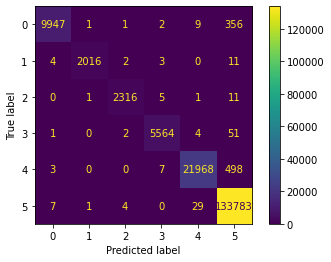

In [24]:
#init a model using scikit-learn's RandomForestClassifier model 
rf_model = RandomForestClassifier(n_estimators=25)

#Fit the model to the training data, 
rf_model = rf_model.fit(X_train, y_train)
rf_predictions_train = rf_model.predict(X_train)

rf_display = ConfusionMatrixDisplay(confusion_matrix(y_train, rf_predictions_train), display_labels=['0', '1', '2','3','4','5'])
rf_display.plot()
print(f"Random Forest accuracy (on X_train): {accuracy_score(y_train, rf_predictions_train):.4f}")

#### Fitting Random Forest to the Validation Data 

In [25]:
#tokenizing p_review on validation data 
X_val = one_hot_vectorizer.fit_transform(X_val_raw.astype('U'))
print(f"X_val.shape = {X_val.shape}")
type(X_val)

X_val.shape = (44153, 10000)


scipy.sparse.csr.csr_matrix

accuracy (on X_train): 0.6133


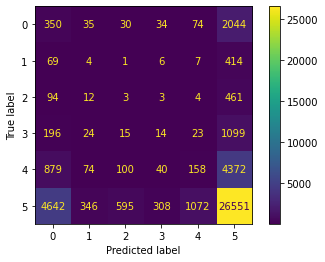

In [26]:
rf_predictions_val = rf_model.predict(X_val)
disp = ConfusionMatrixDisplay(confusion_matrix(y_val, rf_predictions_val), display_labels=['0', '1', '2','3','4','5'])
disp.plot()
print(f"accuracy (on X_train): {accuracy_score(y_val, rf_predictions_val):.4f}")

#### Tuning a Hyperparameter 

In [30]:
rf_tune = True # change this to False once hyperparam value is set 

# A function to create and fit a RF with a specific number of trees
def rf_tune_model(hyperparam_value):
    rf_model = RandomForestClassifier(n_estimators=hyperparam_value, random_state=5)
    rf_model.fit(X_train, y_train)
    y_train_pred_prob = rf_model.predict_proba(X_train)
    y_train_pred = rf_model.predict(X_train)
    y_val_pred_prob = rf_model.predict_proba(X_val)
    y_val_pred = rf_model.predict(X_val)
    train_loss = log_loss(y_train, y_train_pred_prob, labels=['0','1','2','3','4','5'])
    train_acc = accuracy_score(y_train, y_train_pred)
    val_loss = log_loss(y_val, y_val_pred_prob, labels=['0','1','2','3','4','5'])
    val_acc = accuracy_score(y_val, y_val_pred)
    return (train_loss, val_loss, train_acc, val_acc)

# Possible values for the hyperparameter are in the range of 5 to 150 (by 50)
hyp_param_vals = list(range(10,261,50)) # good values for n_estimators

metrics = []

if rf_tune:
    for hp in hyp_param_vals:
        metrics.append(rf_tune_model(hp))

##### Model Performance Results for Hyperparameter Tuning 

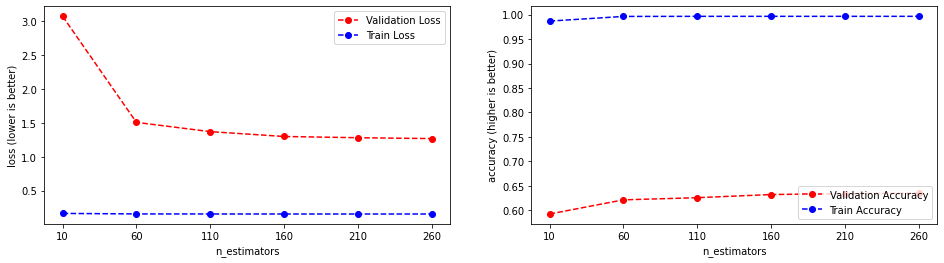

In [31]:
# plot the results of each hyperparameter value specified in rf_tune_model 
if rf_tune:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    ax1.set_xticks(hyp_param_vals)
    ax1.set(xlabel="n_estimators", ylabel="loss (lower is better)")
    ax1.plot(hyp_param_vals, [metric[1] for metric in metrics], '--ro') # validation loss
    ax1.plot(hyp_param_vals, [metric[0] for metric in metrics], '--bo') # training loss
    ax1.legend(["Validation Loss", "Train Loss"], loc=1)

    ax2.set_xticks(hyp_param_vals)
    ax2.set(xlabel="n_estimators", ylabel="accuracy (higher is better)")
    ax2.plot(hyp_param_vals, [metric[3] for metric in metrics], '--ro') # validation accuracy
    ax2.plot(hyp_param_vals, [metric[2] for metric in metrics], '--bo') # training accuracy
    ax2.legend(["Validation Accuracy", "Train Accuracy"], loc=4)

In [38]:
# a data frame containing hyperparam values, second row containing validation loss, third row containing validation accuracy

if rf_tune_model:
  tuning_data = {'Hyperparameter Values': hyp_param_vals, 
                 'Log Loss': [round(metric[1],2) for metric in metrics], 
                 'Accuracy Score': [round(metric[3],2) for metric in metrics]}
  tuning_results = pd.DataFrame(tuning_data)
  print(tuning_results)

   Hyperparameter Values  Log Loss  Accuracy Score
0  10                     3.07      0.59          
1  60                     1.51      0.62          
2  110                    1.37      0.63          
3  160                    1.30      0.63          
4  210                    1.28      0.63          
5  260                    1.27      0.63          


## Test Data 

In [39]:
test_path = '/content/drive/MyDrive/NLP-F22/data/pp_test.csv'
df_test = pd.read_csv(test_path)

df_test.head()

X_test = one_hot_vectorizer.fit_transform(df_test['p_review'].astype('U'))
y_test = df_test['rating'].copy().astype('U')
print(f"X_test.shape = {X_test.shape}")
type(X_test)

X_test.shape = (56613, 10000)


scipy.sparse.csr.csr_matrix

In [ ]:
# Re-init a model using scikit-learn's RandomForestClassifier model 
rf_model = RandomForestClassifier(n_estimators=110)

# Re-fit the model to the training data
rf_model = rf_model.fit(X_train, y_train)


Random Forest accuracy (on X_test): 0.4882


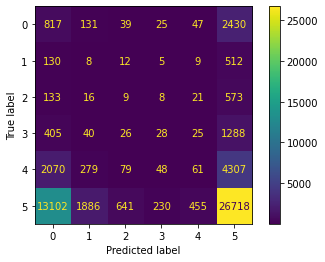

In [42]:
# Now make predictions on the test data 
rf_predictions_test = rf_model.predict(X_test)

# Display accuracy and confusion matrix 
rf_display = ConfusionMatrixDisplay(confusion_matrix(y_test, rf_predictions_test), display_labels=['0', '1', '2','3','4','5'])
rf_display.plot()
print(f"Random Forest accuracy (on X_test): {accuracy_score(y_test, rf_predictions_test):.4f}")

## Conclusions 

Yikes!! 48.82% accuracy is not a good score at all. I do think it is worth backing up before progressing to part 3 and removing the review data where the rating is 0. The reason for this is that there is a wide array of reviews within the 0 rating data that I think is heavily skewing our accuracy based on teh confusion matrix. When people leave a review, but don't rate the recipe themselves, their review gets automatically put into the 0 rating category. Thus, the text sentiment of the review itself has no real meaning for the experiment I am running. 

One other note I want to add is that the shape of the one-hot-vector for `X_train`, `X_val` and `X_test` all varied so I had to use the `max_features` parameter to ensure the model would fit to all three data sets. 


Stay tuned for updates as I address these issues for Part 3 of Recipe Review Analysis! 